In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
from pathlib import Path
%load_ext autoreload
%autoreload 2


In [2]:
# mouse = "mouse2"
# df = utils.load_example_data(mouse)

In [2]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)


['COT_test_data', 'visual_and_COT_data']


In [3]:

# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test', 'test2']


In [4]:
# download the data for a specific animal
mouse = "ACV007"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

receiving incremental file list
ACV007.csv

sent 31,591 bytes  received 380,723 bytes  164,925.60 bytes/sec
total size is 29,862,513  speedup is 72.43


True

In [5]:
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

/tmp/ipykernel_416394/1822815569.py:2: DtypeWarning: Columns (13,14,17,18,27,28,29,30,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


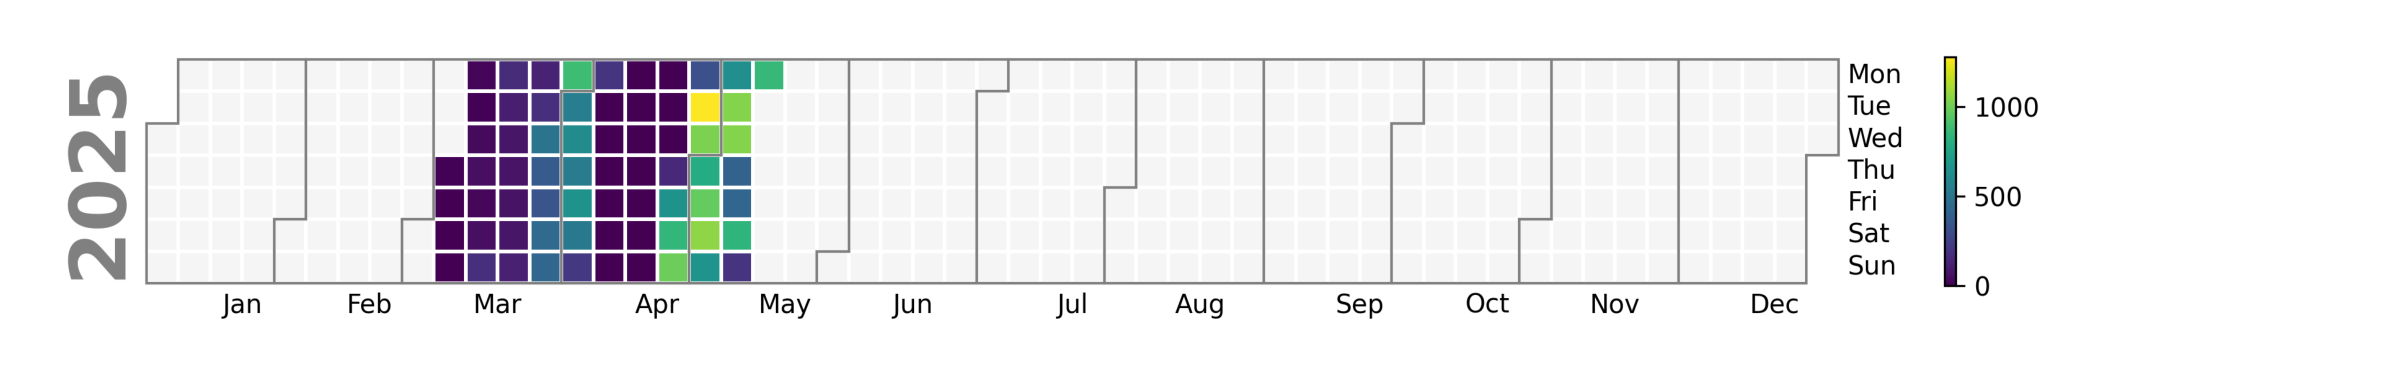

In [6]:
import lecilab_behavior_analysis.plots as plots
import lecilab_behavior_analysis.df_transforms as dft
df = dft.fill_missing_data(df)

# add a column with the date for the day
df = dft.add_day_column_to_df(df)

# create a figure with 1 axis for the calendar plot
import matplotlib.pyplot as plt
fig, ax_cal = plt.subplots(figsize=(10, 5), dpi=300)
# generate the calendar plot
dates_df = dft.get_dates_df(df)
cal_image = plots.rasterize_plot(plots.training_calendar_plot(dates_df), dpi=300)
# paste the calendar plot filling the entire axis
ax_cal.imshow(cal_image)
ax_cal.axis("off")

plt.show()

DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes._PyFloatDType'>, <class 'numpy.dtypes.StrDType'>)

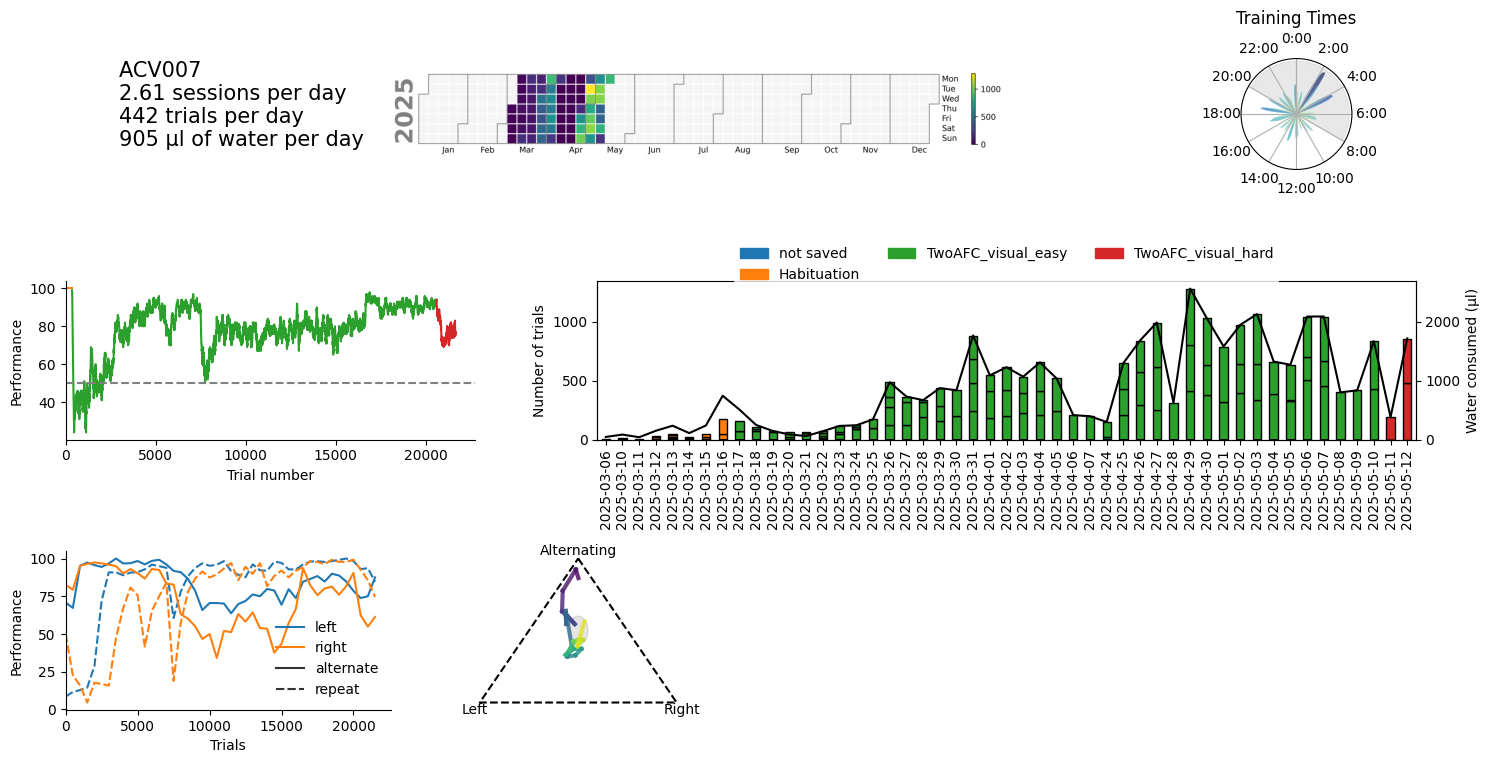

In [7]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, perf_window=100, summary_matrix_plot=False)

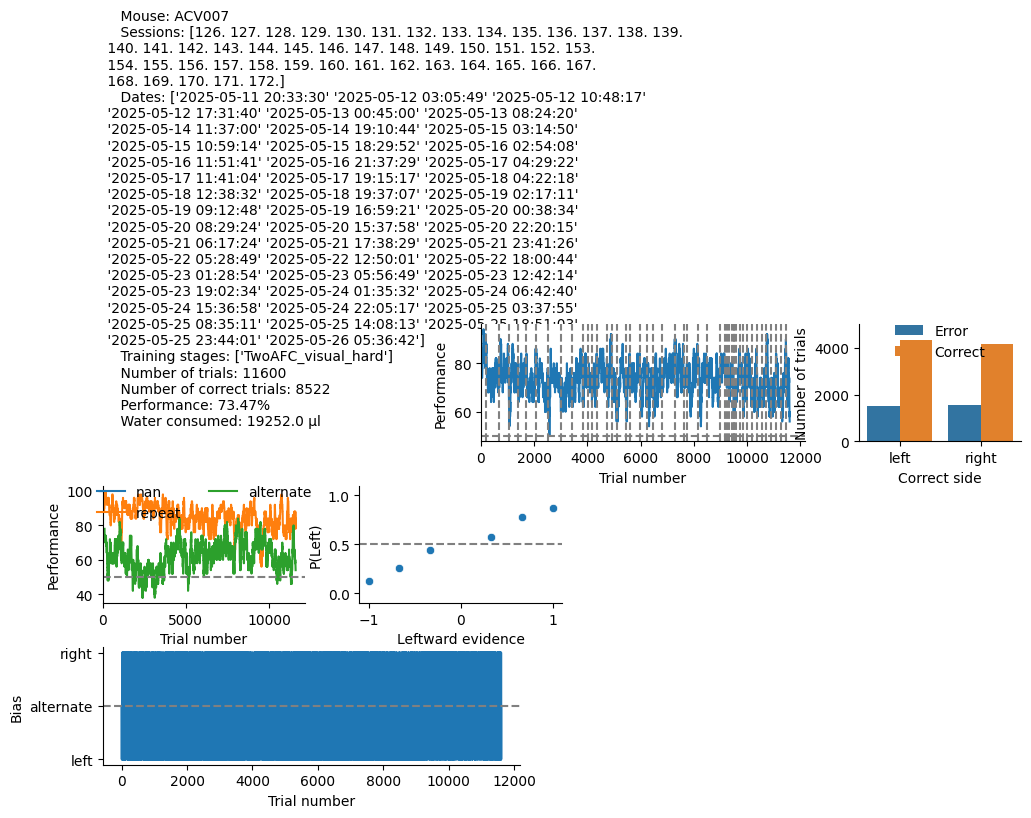

In [6]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
from lecilab_behavior_analysis.df_transforms import add_trial_of_day_column_to_df, add_day_column_to_df
# select the session you want to plot
date = "2025-05-06"
df = add_day_column_to_df(df)
df = add_trial_of_day_column_to_df(df)
sdf = df[df["year_month_day"] == date]
fig = session_summary_figure(sdf, mouse, perf_window=15, width=10, height=5)

In [19]:
df.date.astype('datetime64[ns]').dt.strftime("%Y-%m-%d").head(10)

0    2025-03-06
1    2025-03-06
2    2025-03-06
3    2025-03-06
4    2025-03-06
5    2025-03-06
6    2025-03-06
7    2025-03-06
8    2025-03-06
9    2025-03-10
Name: date, dtype: object

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import df_transforms as dft
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [61]:
df_test = df.dropna(subset = ['visual_stimulus'])

In [62]:
# reduce the dataset to the psychometric version of the task
# Otherwise, we would include a lot of "easy" trials that would bias the fit
df_test = df_test[df_test["current_training_stage"] == "TwoAFC_visual_hard"]

In [69]:
df_test['visual_stimulus_devi'] = df_test['visual_stimulus'].apply(lambda x: abs(round(eval(x)[0] / eval(x)[1], 4)))
# This was good in order to make the fit work for both left and right choices!
df_test['visual_stimulus_devi'] = df_test.apply(
    lambda row: row['visual_stimulus_devi'] if row['correct_side'] == 'left' else -row['visual_stimulus_devi'],
    axis=1
)
df_test['visual_stimulus_diff'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0] - eval(x)[1]))
df_test['visual_stimulus_diff'] = df_test.apply(
    lambda row: row['visual_stimulus_diff'] if row['correct_side'] == 'left' else -row['visual_stimulus_diff'],
    axis=1
)
# !!!!! This introduces a bug!! What would happen on the trials where the mouse has to go right? Which value would be used then?
df_test['left_choice'] = np.where((df_test['correct_side'] == 'left') & (df_test['correct'] == True), 1, 0)

# What you want is a value that goes from 0 to 1, indicating the probability of a left choice.
# For this fits, we really don't care about the correct side, we just want to know if the mouse chose left or right.

# I realized that the way I was plotting this before was using the performance of the mouse and the trials difficulty,
# in order to infer back the probability of a left choice. But we can actually use something simpler and less confusing:

# I had already created a function in the df_transforms module, to get the first choice of a mouse so we can use it here
df_test = dft.add_mouse_first_choice(df_test)
# This creates the column "first_choice" that indicates "left" or "right" for each trial.

# Now we can transform this to 0 and 1, where 0 is right and 1 is left
df_test['left_choice_new'] = df_test['first_choice'].apply(lambda x: 1 if x == 'left' else 0)

# By the way I am naming columns weirdly, just so you can play around with the different solutions and see how they work.
# Once we have what we need, we should clean up the code and use more meaningful names.

Text(0, 0.5, 'Probability of Left Choice')

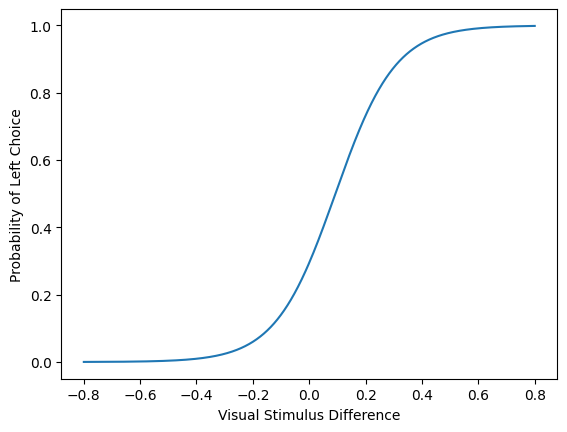

In [58]:
df_test_sorted = df_test.sort_values(by='visual_stimulus_diff')
X = df_test_sorted['visual_stimulus_diff'].values.reshape(-1, 1)
y = df_test_sorted['left_choice'].values.astype(int)
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]
plt.plot(X, y_prob)
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")

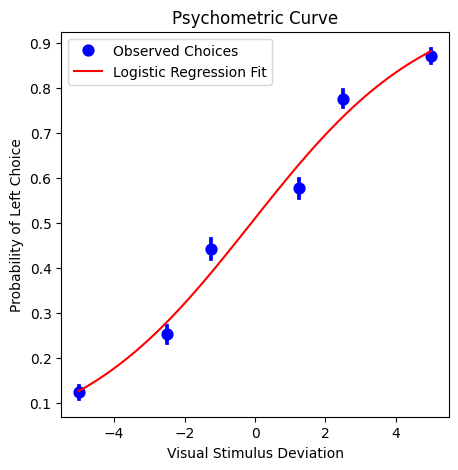

In [83]:
# Now we can fit the data and visualize the results
X = df_test['visual_stimulus_devi'].values.reshape(-1, 1)
y = df_test['left_choice_new'].values.astype(int)
model = LogisticRegression()
model.fit(X, y)

# Now we have a model that predicts the probability of a left choice based on ANY visual stimulus deviation (xs).
# For plotting, we can generate a range of values for the visual stimulus deviation
import numpy as np
xs = np.linspace(df_test['visual_stimulus_devi'].min(), df_test['visual_stimulus_devi'].max(), 100).reshape(-1, 1)
y_prob = model.predict_proba(xs)[:, 1]

# Plot the actual choices of the mouse
fig, ax = plt.subplots(figsize=(5, 5))
sns.pointplot(
    x='visual_stimulus_devi',
    y='left_choice_new',
    data=df_test,
    estimator=lambda x: np.mean(x),
    color='blue',
    markers='o',
    errorbar=("ci", 95),
    ax=ax,
    label='Observed Choices',
    native_scale= True,
    linestyles='',
)

# overlay the fitted logistic regression curve
ax.plot(xs, y_prob, color='red', label='Logistic Regression Fit')
ax.set_xlabel("Visual Stimulus Deviation")
ax.set_ylabel("Probability of Left Choice")
plt.title("Psychometric Curve")
plt.legend()
plt.show()



Text(0, 0.5, 'Probability of Left Choice')

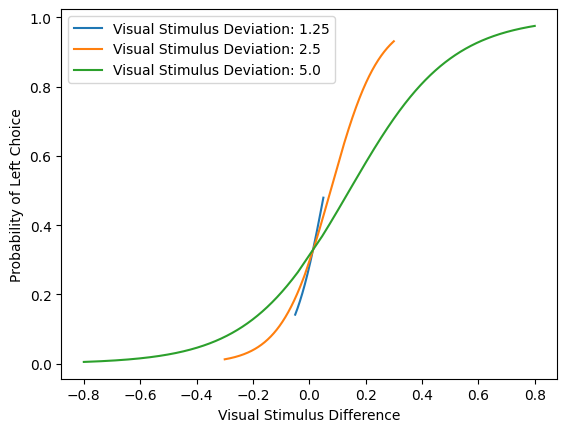

In [ ]:
# It is interesting to compare the effects of the relative difference between the two visual stimuli,
# and the absolute difference between them.

# Maybe what we can do is to train another logistic regression model, adding as well the absolute difference
# between the two visual stimuli, and see how it affects the probability of a left choice.
# Do you know what I mean?

for i in df_test.groupby('visual_stimulus_devi'):
    df_i = i[1].sort_values(by='visual_stimulus_diff')
    X = df_i['visual_stimulus_diff'].values.reshape(-1, 1)
    y = df_i['left_choice'].values.astype(int)
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    plt.plot(X, y_prob, label=f"Visual Stimulus Deviation: {i[0]}")
    plt.legend()
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")